In [ ]:
pip install torch 

     |████████████████████████████████| 150.8 MB 60 kB/s  eta 0:00:01   |█▌                              | 7.2 MB 6.3 MB/s eta 0:00:23     |████████▊                       | 41.2 MB 6.5 MB/s eta 0:00:17     |█████████                       | 41.9 MB 6.5 MB/s eta 0:00:17     |████████████▋                   | 59.2 MB 4.8 MB/s eta 0:00:20     |████████████▊                   | 59.8 MB 4.8 MB/s eta 0:00:19     |█████████████▌                  | 63.4 MB 4.7 MB/s eta 0:00:19     |██████████████████████▎         | 105.0 MB 3.0 MB/s eta 0:00:16     |█████████████████████████▍      | 119.5 MB 5.6 MB/s eta 0:00:06     |████████████████████████████▌   | 134.1 MB 5.2 MB/s eta 0:00:04     |█████████████████████████████▊  | 140.0 MB 9.1 MB/s eta 0:00:02
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip uninstall torch torchvision torchaudio -y

Found existing installation: torch 2.2.2
Uninstalling torch-2.2.2:
  Successfully uninstalled torch-2.2.2
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install --upgrade jupyter jupyterlab ipykernel

     |████████████████████████████████| 11.6 MB 6.9 MB/s eta 0:00:01
     |████████████████████████████████| 117 kB 13.8 MB/s eta 0:00:01
     |████████████████████████████████| 433 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 59 kB 11.3 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 16.3 MB/s eta 0:00:01
     |████████████████████████████████| 383 kB 15.4 MB/s eta 0:00:01
     |████████████████████████████████| 69 kB 8.6 MB/s  eta 0:00:01
     |████████████████████████████████| 4.8 MB 7.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 5.7 MB/s  eta 0:00:01
     |████████████████████████████████| 257 kB 23.2 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 7.7 MB/s  eta 0:00:01
     |████████████████████████████████| 58 kB 9.8 MB/s  eta 0:00:01
     |████████████████████████████████| 78 kB 6.3 MB/s eta 0:00:011
     |████████████████████████████████| 10

In [5]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
#import torch

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns

# Density Evaluation with more precision
#from torch.distributions.multivariate_normal import MultivariateNormal

## Autograd packages

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence
#import ot #Optimal Transport


## Import functions for the experiment : 

#from experiment_functions import *
#from IPLA_Exp_Functions import *


In [3]:
def grad_multimodal_opti(x, weights, centers, covariances): 
    
    n_components = len(weights)

    gradient = np.zeros(x.shape)

    covariance = covariances[0] #Warning : we assume that all the covariances are the same

    cov_inv = np.linalg.inv(covariance)

    pdf_tot = np.zeros(x.shape[0])
    
    for i in range(n_components):
        center = centers[i]
        weight = weights[i]

        pdf = multivariate_normal.pdf(x, mean = center, cov = covariance) 

        pdf_tot += pdf * weight #Denominator term
            
        diff = x - center

        gradient += weight * (np.einsum('ij,kj->ik', cov_inv, diff).T * pdf[:, np.newaxis]) #Numerator term


    gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])

    return gradient


In [4]:
def generate_multimodal(centers, covariances, weights, plot_sample=None, grad_sample = None): 

    n_components = len(weights)

    if n_components != len(centers) or n_components != len(covariances):
        raise ValueError('The number of centers, covariances and weights should be the same')
    
    graph_len = max(max(abs(centers[:, 0])),  max(abs(centers[:, 1]))) + 5

    x_axis = np.linspace(-graph_len, graph_len, 500)
    y_axis = np.linspace(-graph_len, graph_len, 500)

    xx_axis, yy_axis = np.meshgrid(x_axis, y_axis)
    pos = np.dstack((xx_axis, yy_axis))
    
    # Compute the pdf for each center and sum them

    pdf = np.zeros(xx_axis.shape)

    for i in range(n_components):
        center = centers[i]
        covariance = covariances[i]
        weight = weights[i]

        rv = multivariate_normal(center, covariance) # On fixe la normale
        pdf += weight * rv.pdf(pos) # On évalue la densité de cette loi sur la grille des points et on somme (pondéremment)

    # Plot the result

    plt.figure(figsize=(8, 8))
    plt.contourf(xx_axis, yy_axis, pdf, levels=50, cmap='Blues', alpha=0.4) 
    ## levels : nombre de niveaux de couleurs ; cmap : choix de la palette de couleurs ; alpha : transparence
    plt.colorbar()
    
    if plot_sample is not None:
        x = plot_sample[:, 0]
        y = plot_sample[:, 1]
        plt.scatter(x, y, alpha=0.5, s = 8, color = 'red')

    if grad_sample is not None : 
        grad_x = grad_sample[:, 0]
        grad_y = grad_sample[:, 1]
        print(grad_x, grad_y)
        plt.quiver(x, y, grad_x, grad_y)

    plt.title('Mixture of Gaussian Distributions density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()



In this experiment, we consider a Parametric latent variable models (LVM) in a specific setting. In this context, we will be able to do a fair comparison between several algorithms that aim to estimate the Maximum Marginal Likelihood of the model. 
\\ \\
Let us consider a generic latent variable model as $p_\theta(x,y)$, parameterised by $\theta \in \mathbb{R}^{d_\theta}$, for fixed data $y \in \mathbb{R}^{d_y}$, and latent variables $x \in \mathbb{R}^{d_x}$. This model is considered for fixed observed data $y$, thus formally we see the statistical model as a real-valued mapping $p_\theta(x,y) : \mathbb{R}^{d_x} \times \mathbb{R}^{d_\theta} \rightarrow \mathbb{R}$. The task we are interested in is to estimate the parameter $\theta$ that explains the fixed dataset $y$. Often, this task is achieved via the maximum likelihood estimation (MLE). In accordance with this, in our setting, due to the presence of latent variables, we aim at finding the maximum marginal likelihood estimate (MMLE), more precisely, our problem takes the form

\begin{equation}
\theta^\ast \in \arg \max_{\theta \in \mathbb{R}^{d_\theta}} \log p_\theta(y),
\end{equation}

where $p_\theta(y) := \int p_\theta(x,y) \, dx$ is the marginal likelihood.
\\ 
The main difficulty is that, very often, this integral is intractable. This is where the different algorithms studied appear. 
\\ \\
With the notation $U(\theta, x) = -\log p_\theta(x,y)$, the $\theta$-gradient of $\log p_\theta(y)$ is given as

\begin{equation}
\nabla_\theta \log p_\theta(y) = - \frac{\int \nabla_\theta U(\theta, x) p_\theta(x, y) \, dx}{p_\theta(y)} = - \int \nabla_\theta U(\theta, x) p_\theta(x \mid y) \, dx,
\end{equation}



In this experiment, we consider the following Latent Variable Model: 

- $\mathbf{y} = \theta^{*}\mathbf{x} + \mathbf{z}$ where:
- $\mathbf{y} \in \mathbb{R}$ is the observed data,
- $\theta^{*} \in \mathbb{R}^{2}$ is the "ground truth" parameter that links the latent variables and the observed data.

To generate $\mathbf{y}$, the observed data, we first draw $x^{*} \sim p_{0}$ and set $\mathbf{y} := \theta^{*}x + \mathbf{z}$, where $\mathbf{z} \sim \mathcal{N}(0, \sigma_y^{2})$ 

For a given dimension $d_x$, we consider the prior distribution $p_0$, which is a mixture of 25 Gaussian random variables. The components have mean $\mu_{i,j} := (8i, 8j, \ldots, 8i, 8j) \in \mathbb{R}^{d_x}$ for $(i, j) \in \{-2, -1, 0, 1, 2\}^2$ and unit variance. We have set the associated unnormalized weights $\omega_{i,j} = 1.0$. This choice of Parametric Model is convenient because it allows the Posterior Distribution to stay in the same parametric family of distribution : it is a Gaussian Mixture. 

The joint density of the variables, $ p_\theta(x, y) $, is given by : $ p_\theta(x, y) = p_\theta(y \mid x) p_{0}(x) $, where : 
- $ p_\theta(y \mid x) = \mathcal{N}(y \mid \theta^{*}x, \sigma_y^2)$
- $ p_{0}(x) = \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) $

Then, given the log-densities of the conditional log-likelihood of the observed data $y$ and of the prior distribution : 

$\log \mathcal{N}(y \mid \theta x, \sigma_y^2) = -\frac{1}{2} \log(2\pi \sigma_y^2) - \frac{1}{2\sigma_y^2} (y - \theta x)^T (y - \theta x)$

$\log p_{\mathbf{0}}(x) = \log \left( \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) \right)$

We are able to compute the gradient of $ p_\theta(x, y) $ with respect to the parameters $\theta$ and $x$ : 

\begin{equation}
\nabla_x \log p_{\theta}(x, y) = \frac{1}{\sigma_y^2} \theta^T (y - \theta x) + \sum_{k=1}^K \frac{\mathcal{N}(x \mid \mu_k, I)}{K p_{0}(x)} \left(- (x - \mu_k)\right)
\end{equation}

\begin{equation}
\nabla_{\theta} \log p_{\theta}(x, y) = \frac{1}{\sigma_y^2} (y - \theta x) x^T
\end{equation}


------------------------------------------------------------------------------------------------------------------------------------------
First, we define a function to generate the parameters of our prior distribution, given : 
- dx
- size of the hypercube that contains our modes

In [6]:
def gen_prior_param(dx, size_cube): 
    """
    Function to generate the parameters of the prior distribution of the experiment
    """
    
    semi_size = size_cube // 2
    range_values = np.array([-2, -1, 0, 1, 2])  # Values for i and j
    grid = np.array(np.meshgrid(range_values, range_values)).T.reshape(-1, 2)  

    means = []
    for (i, j) in grid:
        mean_vector = np.tile([semi_size*i, semi_size*j], dx // 2)  # Create a pattern 
        means.append(mean_vector)

    means_prior = np.array(means)

    # Verify the shape
    print("Shape of means array:", means_prior.shape)

    ## Covariance
    covariances_prior = np.array([np.eye(dx)] * 25)
    print(f"Unit Covariance Matrix: {covariances_prior[0]}")

    # Weights
    weights_prior = np.ones(25) / 25
    print(f'Weights vector : {weights_prior}')

    return means_prior, covariances_prior, weights_prior

In [73]:
params = gen_prior_param(20, 40)

Shape of means array: (25, 20)
Unit Covariance Matrix: [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


------------------------------------------------------------------------------------------------------------------------------------------
We generalize the function to sample from a Gaussian Mixture of dimension $dx$, given its parameters (means, covariances, weights)

In [8]:
def sample_prior_dx(nb_particle_gen, centers_prior, covariances_prior, weights_prior) : 
    """

    Function to sample from a Gaussian Mixture given its parameters (means, covariances and weights) and the wanted size of the sample. 
    In the context of the experiment, we use it to initialize the algorithm and to manually generate the observation Y

    """

    dx = centers_prior[0].shape[0]
    nb_components = len(weights_prior)

    x_star = np.zeros((nb_particle_gen, dx))

    # Selection of the component randomly
    component_choices = np.random.choice(nb_components, size=nb_particle_gen, p=weights_prior) #choix aléatoire entre les normales de la mixture (pondéré)

    for i in range(nb_components):

        num_samples = np.sum(component_choices == i) #

        if num_samples > 0:

            #x_star[component_choices == i] = np.random.multivariate_normal(mean=centers[i], cov=covariances[i], size=num_samples) #pour les indices où l'on a tiré la composante en question on tire selon celle-ci
            x_star[component_choices == i] = np.random.multivariate_normal(mean=centers_prior[i], cov=covariances_prior[i], size=num_samples) 

    return x_star

In [74]:
x_start = sample_prior_dx(1000, params[0], params[1], params[2])
x_start_2 = sample_prior_dx(1000, params[0], params[1], params[2])

------------------------------------------------------------------------------------------------------------------------------------------
We write a little function to plot the first 2 dimensions of two samples (max)

PS : In the article -> 1 sample drawn from the right distribution and another one from the approximation

In [10]:
def plot_sample_dx(sample_to_plot_1, desc_sample_1 = '', sample_to_plot_2=None, desc_sample_2 = ''): 

    sns.set(style="whitegrid")
    
    plt.figure(figsize=(10, 10))
    plt.scatter(sample_to_plot_1[:, 0], sample_to_plot_1[:, 1], alpha=0.6, s=50, color="red", label = desc_sample_1, edgecolor='k')
    
    if sample_to_plot_2 is not None: 

        plt.scatter(sample_to_plot_2[:, 0], sample_to_plot_2[:, 1], alpha=0.05, s=50, color=sns.color_palette("husl", 8)[2], label = desc_sample_2, edgecolor='k')
    
    plt.title('Sample from a Gaussian Mixture Distribution', fontsize=16, weight='bold')
    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)
    
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.gca().set_facecolor('#f7f7f7')
    
    plt.legend()
    plt.show()
 

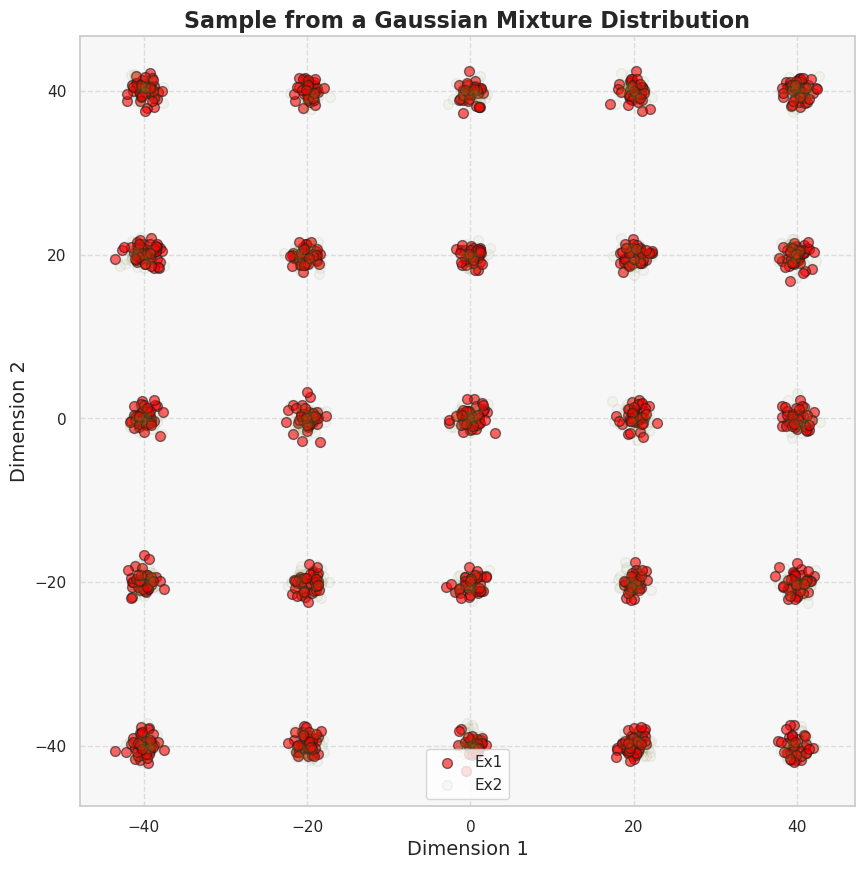

In [75]:
plot_sample_dx(x_start, desc_sample_1 = 'Ex1',sample_to_plot_2 = x_start_2, desc_sample_2 = "Ex2")


------------------------------------------------------------------------------------------------------------------------------------------
We generate the function to generate the initial $y_obs$ as in the article : 

To generate $\mathbf{y}$, the observed data, we first draw $x^{*} \sim p_{0}$ and set $\mathbf{y} := \theta^{*}x + \mathbf{z}$, where $\mathbf{z} \sim \mathcal{N}(0, \sigma_y^{2})$ 

In [12]:
def generate_obs_dx(x_star, theta, sigma_y) : 
     """
    
    Function that generates the observed data point as it is explained in the Appendix of the paper : y = Hx + z. 
    x is drawn according to the prior distribution and z is a gaussian noise whose parameters are defined in the Appendix. 

    """
    
     noise = np.random.normal(0, sigma_y**2)

     y_obs = np.dot(theta, x_star.T) + noise

     return y_obs

In [76]:
x_star = sample_prior_dx(1, params[0], params[1], params[2])
#theta_star = np.random.uniform(0, 1, 80)
theta_star = np.random.uniform(0, 1, 20)

y_obs_dx = generate_obs_dx(x_star, theta_star, 0.1)
y_obs_dx

array([121.21712822])

------------------------------------------------------------------------------------------------------------------------------------------
We define the function that returns the parameters of the posterior Distribution (Gaussian Mixture), given the $\theta$ and the $y_{obs}$ that we have : 

In [17]:

def post_params_dx(theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs, plot = False):
    """
    
    In the context of this experiment, the posterior distribution is also a Gaussian Mixture whose parameters can be analytically computed. 
    This function permits to generates those parameters given the parameters of the model and of the prior distribution.  

    """

    dx = theta.shape[0]

    nb_components = weights_prior.shape[0]

    theta_reshape = theta.reshape(1, dx) #To behave as a matrix

    Sigma_post = np.linalg.inv(np.eye(dx) + (1 / sigma_y**2) * np.outer(theta_reshape.T, theta_reshape))

    covariances_posteriori = np.full((nb_components, dx, dx), Sigma_post)

    weights_posteriori = np.zeros(nb_components)

    centers_posteriori = np.zeros((nb_components, dx))

    for i in range(nb_components): 
        
        M = (theta * (y_obs / (sigma_y ** 2)))
        
        centers_posteriori[i] = np.dot(Sigma_post, M + centers_prior[i]) ## WTF OUBLI M ? 

        ## Weights
        mean_pdf = theta @ centers_prior[i].T

        covariance_pdf = sigma_y**2 + np.dot(theta_reshape, theta_reshape.T)
    
        weights_posteriori[i] = weights_prior[i] * norm.pdf(y_obs, mean_pdf, covariance_pdf)

    weights_posteriori = weights_posteriori / np.sum(weights_posteriori)

    return centers_posteriori, covariances_posteriori, weights_posteriori

/tmp/ipykernel_14966/562508489.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights_posteriori[i] = weights_prior[i] * norm.pdf(y_obs, mean_pdf, covariance_pdf)
/tmp/ipykernel_14966/1176519985.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


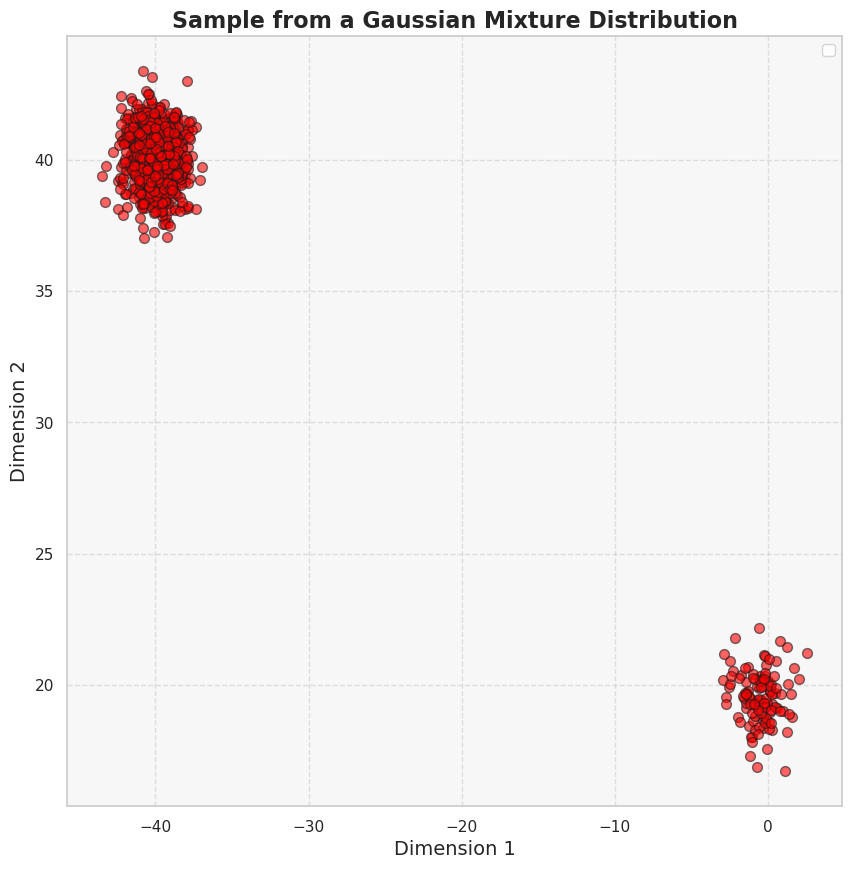

In [77]:
centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_star, 0.1, params[0], params[1], params[2], y_obs_dx)

sample_post = sample_prior_dx(1000, centers_posteriori, covariances_posteriori, weights_posteriori)

plot_sample_dx(sample_post)

------------------------------------------------------------------------------------------------------------------------------------------
We want to be sure that the gradients are correctly computed, therefore, we define a function that we will proceed a gradient descent on the posterior distribution and we will make sure that every particles converge to a mode.  

In [19]:
def grad_descent_post_dx(sample_init, step_size, nb_iter, centers_prior, covariances_prior, weights_prior, y_obs, sigma_y, true_theta, plot = True): 

    sample_size = sample_init.shape[0]
    dim_var = sample_init.shape[1]

    traj = np.zeros((nb_iter, sample_size, dim_var))

    centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
    grad = np.zeros((sample_size, dim_var))
    for i in tqdm(range(nb_iter)): 
        
        #grad = grad_multimodal_opti(sample_init, weights_post, centers_post, covariances_post)
        grad = ((1/sigma_y**2) * true_theta[:, np.newaxis] * (y_obs - np.dot(true_theta, sample_init.T))).T 

        grad += grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior)
        #grad += np.nan_to_num(grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior), nan = 0)

        sample_init += step_size * grad # + np.sqrt(step_size * 2) * np.random.randn(sample_size, dim_var)

        traj[i] = sample_init

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample_init, "ULA", sample_post, "True Posterior Sample") 

    return sample_init


/tmp/ipykernel_14966/562508489.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights_posteriori[i] = weights_prior[i] * norm.pdf(y_obs, mean_pdf, covariance_pdf)
  0%|          | 0/5000 [00:00<?, ?it/s]/tmp/ipykernel_14966/3562615471.py:26: RuntimeWarning: invalid value encountered in divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/tmp/ipykernel_14966/3562615471.py:26: RuntimeWarning: divide by zero encountered in divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 5000/5000 [01:45<00:00, 47.21it/s]


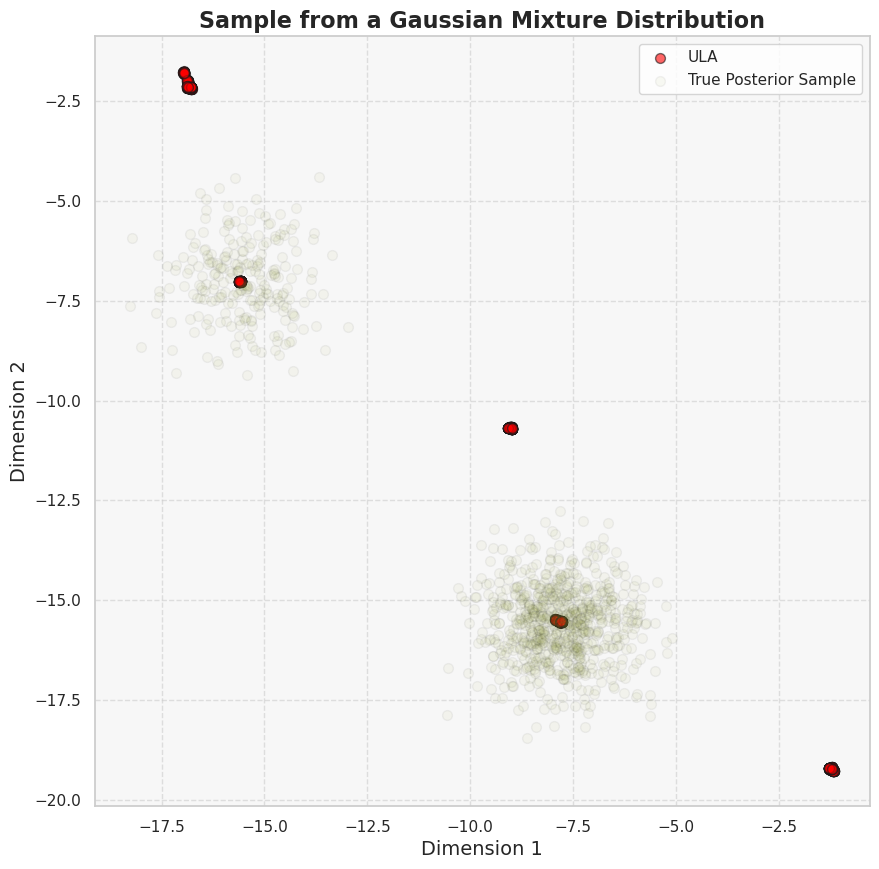

Descent NaN 136


In [29]:
sample_init = sample_prior_dx(1000, params[0], params[1], params[2])

traj_descent = grad_descent_post_dx(sample_init, 0.001, 5000, params[0], params[1], params[2], y_obs_dx, 0.1, theta_star, True)

print(f'Descent NaN {np.sum(np.isnan(traj_descent)) // 20}')

In [82]:
centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_star, 0.1, params[0], params[1], params[2], y_obs_dx)

/tmp/ipykernel_14966/562508489.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights_posteriori[i] = weights_prior[i] * norm.pdf(y_obs, mean_pdf, covariance_pdf)


/tmp/ipykernel_14966/1176519985.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


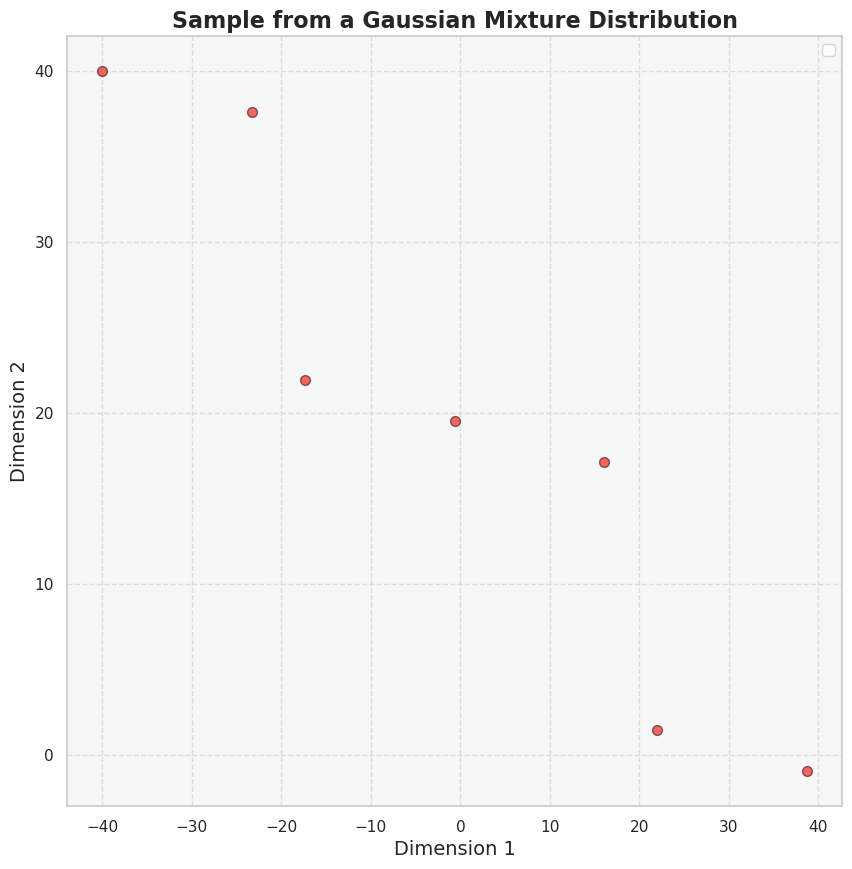

In [93]:
plot_sample_dx(centers_posteriori[weights_posteriori > 1e-40][:, :2], "")


/tmp/ipykernel_14966/1176519985.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


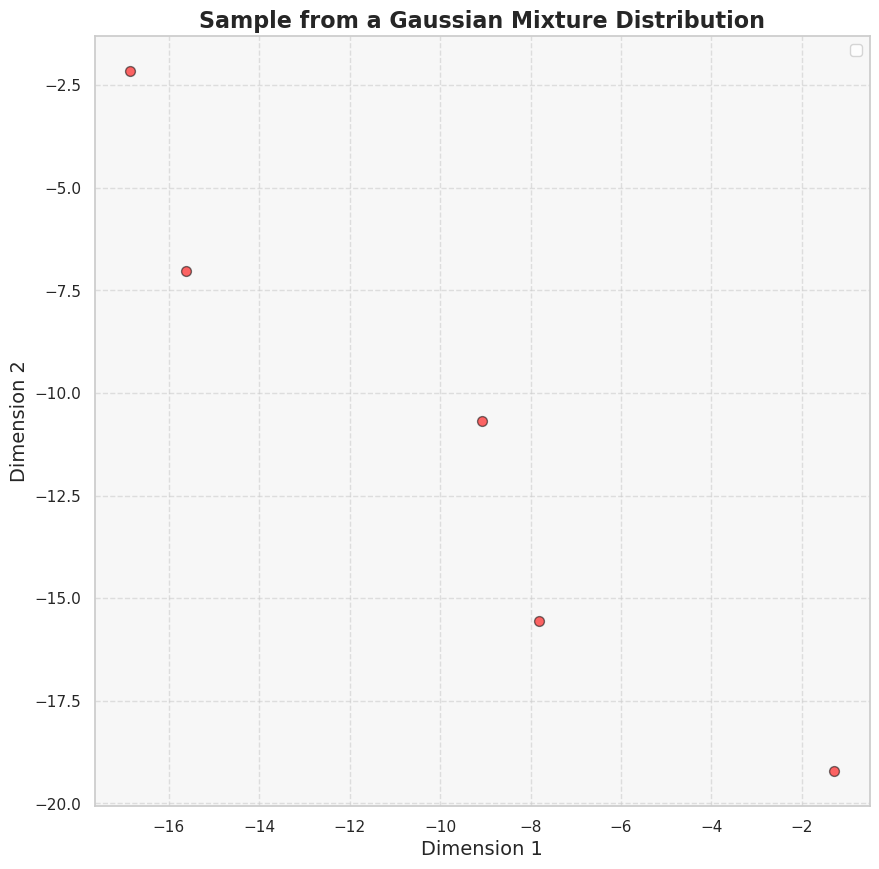

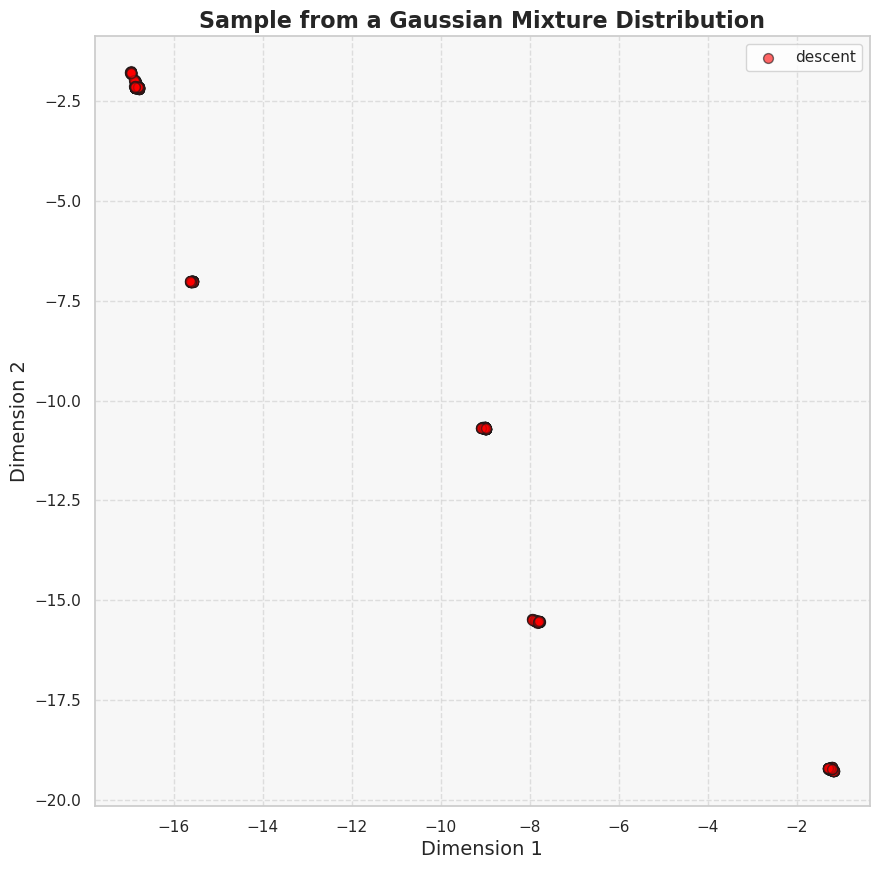

In [63]:
plot_sample_dx(centers_posteriori[weights_posteriori > 0.0000001][:, :2], "")
plot_sample_dx(traj_descent[:, :2] , "descent")

------------------------------------------------------------------------------------------------------------------------------------------
Here we define the function that runs the Unadjusted Langevin Algorithm to intent to sample from the posterior distribution without knowing its exact parameters, but only having an oracle on the score vector : $\nabla_x p_\theta(x \mid y)$. 

It is a reasonable assumption because we know the posterior distribution up to a normalizing constant, it means that it doesn't affect the derivative of the log-density. 

In [31]:
def ULA_post_dx(sample_init, step_size, nb_iter, centers_prior, covariances_prior, weights_prior, y_obs, sigma_y, true_theta, plot = True): 

    sample_size = sample_init.shape[0]
    dim_var = sample_init.shape[1]

    traj = np.zeros((nb_iter, sample_size, dim_var))

    centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)

    for i in tqdm(range(nb_iter)): 
        
        #grad = grad_multimodal_opti(sample_init, weights_post, centers_post, covariances_post)
        grad = ((1/sigma_y**2) * true_theta[:, np.newaxis] * (y_obs - np.dot(true_theta, sample_init.T))).T 

        grad += grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior)
        #grad += np.nan_to_num(grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior), nan = 0)

        sample_init += step_size * grad + np.sqrt(step_size * 2) * np.random.randn(sample_size, dim_var)

        traj[i] = sample_init

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample_init, "ULA", sample_post, "True Posterior Sample") 

    return sample_init


ICI PLUS ELOIGNE

/tmp/ipykernel_14966/562508489.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights_posteriori[i] = weights_prior[i] * norm.pdf(y_obs, mean_pdf, covariance_pdf)
  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_14966/3562615471.py:26: RuntimeWarning: divide by zero encountered in divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/tmp/ipykernel_14966/3562615471.py:26: RuntimeWarning: invalid value encountered in divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
100%|██████████| 2000/2000 [00:31<00:00, 63.94it/s]


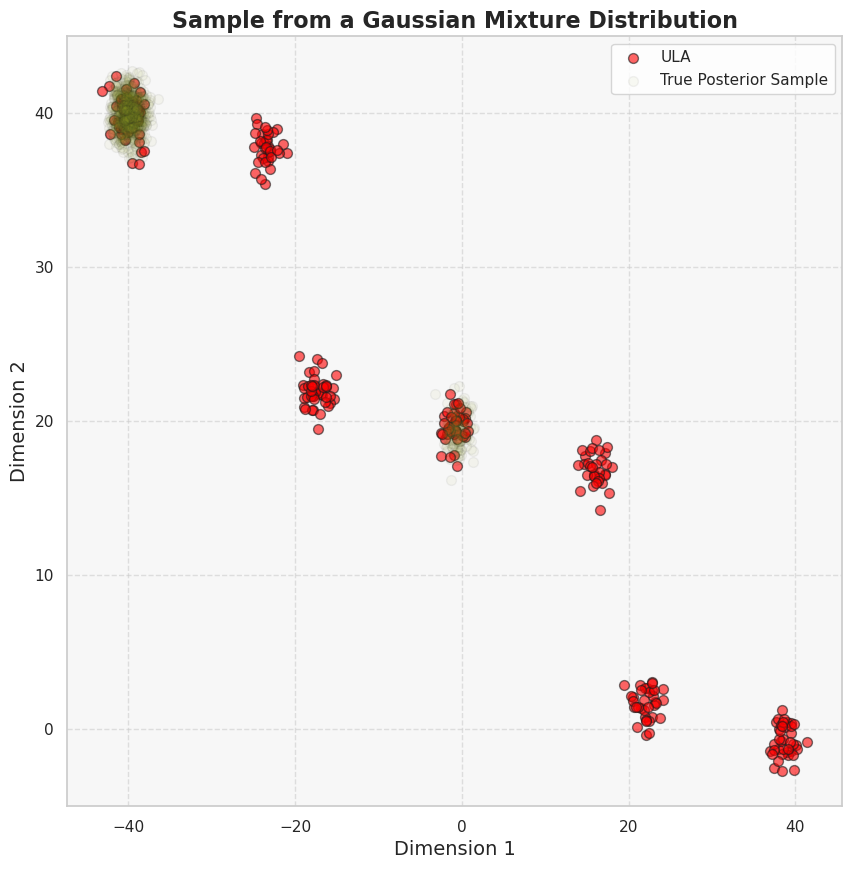

Normal NaN 720


In [80]:
sample_init = sample_prior_dx(1000, params[0], params[1], params[2])

traj = ULA_post_dx(sample_init, 0.001, 2000, params[0], params[1], params[2], y_obs_dx, 0.1, theta_star, True)

print(f'Normal NaN {np.sum(np.isnan(traj))//20}')

/tmp/ipykernel_14966/562508489.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights_posteriori[i] = weights_prior[i] * norm.pdf(y_obs, mean_pdf, covariance_pdf)
  0%|          | 0/20000 [00:00<?, ?it/s]/tmp/ipykernel_14966/3562615471.py:26: RuntimeWarning: invalid value encountered in divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/tmp/ipykernel_14966/3562615471.py:26: RuntimeWarning: divide by zero encountered in divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/opt/conda/lib/python3.12/site-packages/scipy/stats/_covariance.py:630: RuntimeWarning: invalid value encountered in matmul
  return x @ self._LP
100%|██████████| 20000/20000 [06:35<00:00, 50.63it/s]


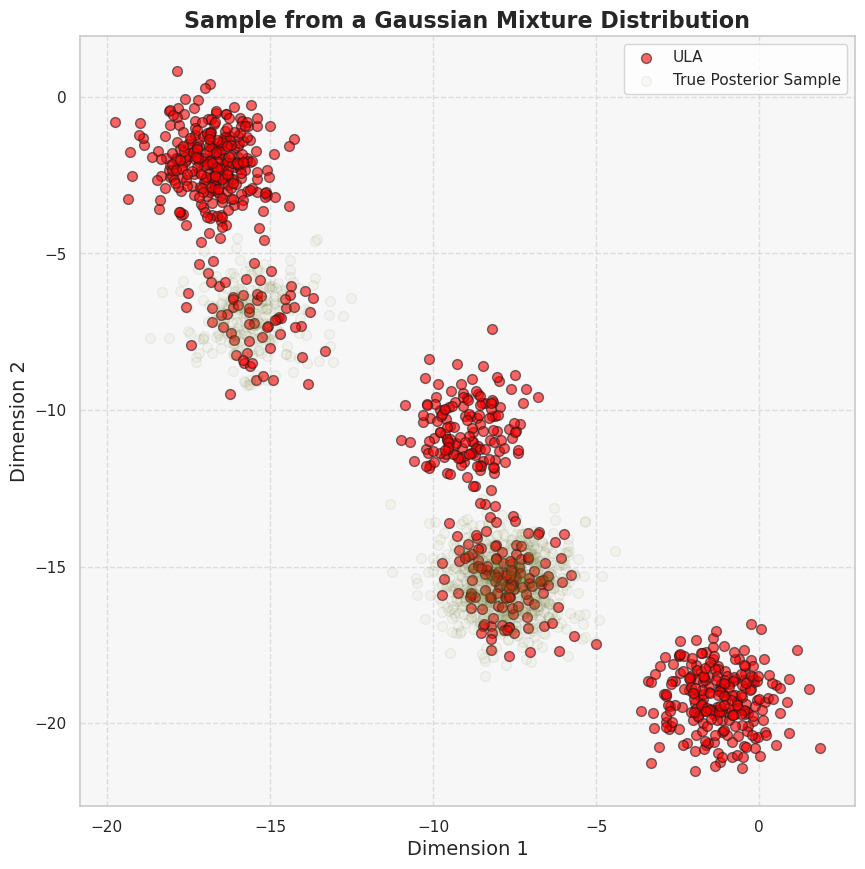

Normal NaN 117


In [64]:
sample_init = sample_prior_dx(1000, params[0], params[1], params[2])

traj = ULA_post_dx(sample_init, 0.001, 20000, params[0], params[1], params[2], y_obs_dx, 0.1, theta_star, True)

print(f'Normal NaN {np.sum(np.isnan(traj))//20}')

------------------------------------------------------------------------------------------------------------------------------------------
Here we define the function that runs the Unadjusted Langevin Algorithm with Dilation Path to intent to sample more efficiently from the posterior distribution without knowing its exact parameters, but only having an oracle on the score vector : $\nabla_x p_\theta(x \mid y)$. 

It is a reasonable assumption because we know the posterior distribution up to a normalizing constant, it means that it doesn't affect the derivative of the log-density. 

In [34]:
def ULA_dilation_exp(sample_init, step_size, nb_iter, centers_prior, covariances_prior, weights_prior, y_obs, sigma_y, true_theta, start_schedule,
                    end_schedule, plot = True): 
    
    sample_size = sample_init.shape[0]
    dim_var = sample_init.shape[1]

    traj = np.zeros((nb_iter, sample_size, dim_var))

    time_SDE = 0

    for i in tqdm(range(nb_iter)): 

        time_SDE += step_size

        schedule = np.minimum(start_schedule + np.minimum(end_schedule, time_SDE) / end_schedule, 1)

        gamma = 1 / np.sqrt(schedule)

        gamma_sample = gamma * sample_init
        
        #grad = grad_multimodal_opti(sample_init, weights_test, centers_test, covariances_test)
        grad = gamma * ((1/sigma_y**2) * true_theta[:, np.newaxis] * (y_obs - np.dot(true_theta, gamma_sample.T))).T 

        grad += gamma * grad_multimodal_opti(gamma_sample, weights_prior, centers_prior, covariances_prior)

        taming_coef = step_size / (1 + step_size * np.linalg.norm(grad, axis = 1))

        grad_update = taming_coef[:, np.newaxis] * grad

        sample_init += grad_update + np.sqrt(step_size * 2) * np.random.randn(sample_size, dim_var)

        traj[i] = sample_init

    
    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample_init, "ULA with Dilation Path", sample_post, "True Posterior Sample") 

    return sample_init
    

ICI PLUS ELOIGNE

  2%|▏         | 30/2000 [00:00<00:37, 52.41it/s]/tmp/ipykernel_14966/3562615471.py:26: RuntimeWarning: invalid value encountered in divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/tmp/ipykernel_14966/3562615471.py:26: RuntimeWarning: divide by zero encountered in divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
  2%|▏         | 36/2000 [00:00<00:37, 52.42it/s]/tmp/ipykernel_14966/139911674.py:28: RuntimeWarning: invalid value encountered in multiply
  grad_update = taming_coef[:, np.newaxis] * grad
100%|██████████| 2000/2000 [00:35<00:00, 56.70it/s]
/tmp/ipykernel_14966/562508489.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights_posteriori[i] = weights_prior[i] * norm.pdf(y_obs, mean_pdf, covariance_pdf)


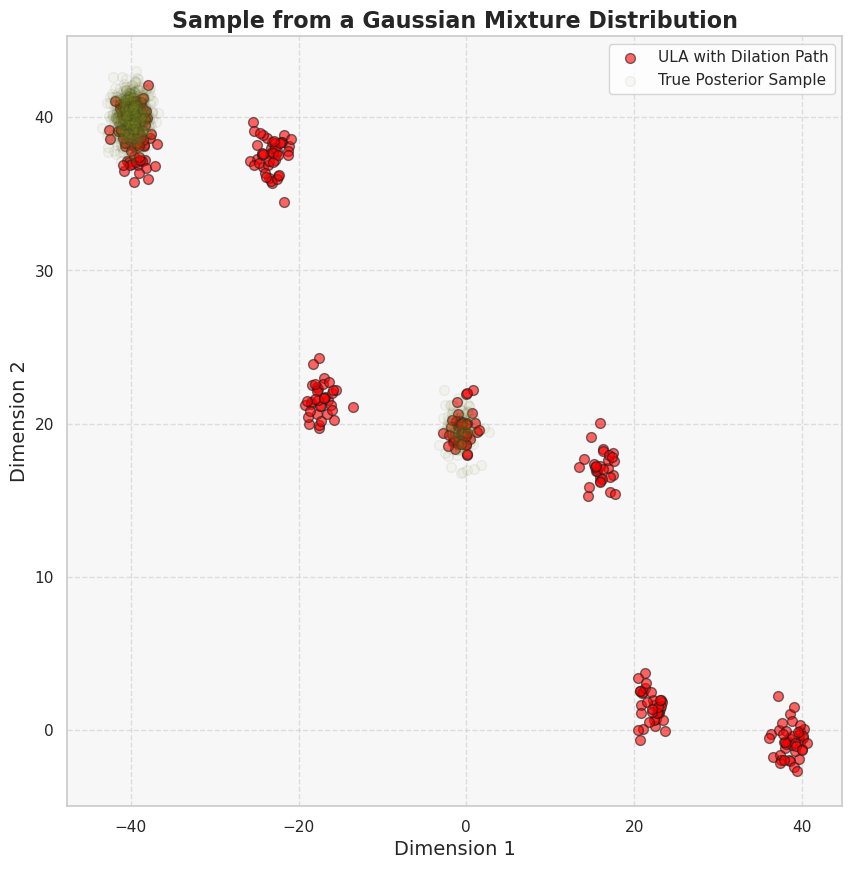

Dilation NaN 682


In [94]:
sample_init = sample_prior_dx(1000, params[0], params[1], params[2])

dilation_traj = ULA_dilation_exp(sample_init, 0.001, 2000, params[0], params[1], params[2], y_obs_dx, 0.1, theta_star, 0.8, 2, True)

print(f'Dilation NaN {np.sum(np.isnan(dilation_traj))//20}')

  0%|          | 22/5000 [00:00<01:10, 70.33it/s]/tmp/ipykernel_14966/3562615471.py:26: RuntimeWarning: invalid value encountered in divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/tmp/ipykernel_14966/3562615471.py:26: RuntimeWarning: divide by zero encountered in divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
  1%|          | 53/5000 [00:00<01:12, 68.62it/s]/tmp/ipykernel_14966/139911674.py:28: RuntimeWarning: invalid value encountered in multiply
  grad_update = taming_coef[:, np.newaxis] * grad
100%|██████████| 5000/5000 [01:22<00:00, 60.66it/s]
/tmp/ipykernel_14966/562508489.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights_posteriori[i] = weights_prior[i] * norm.pdf(y_obs, mean_pdf, covariance_pdf)


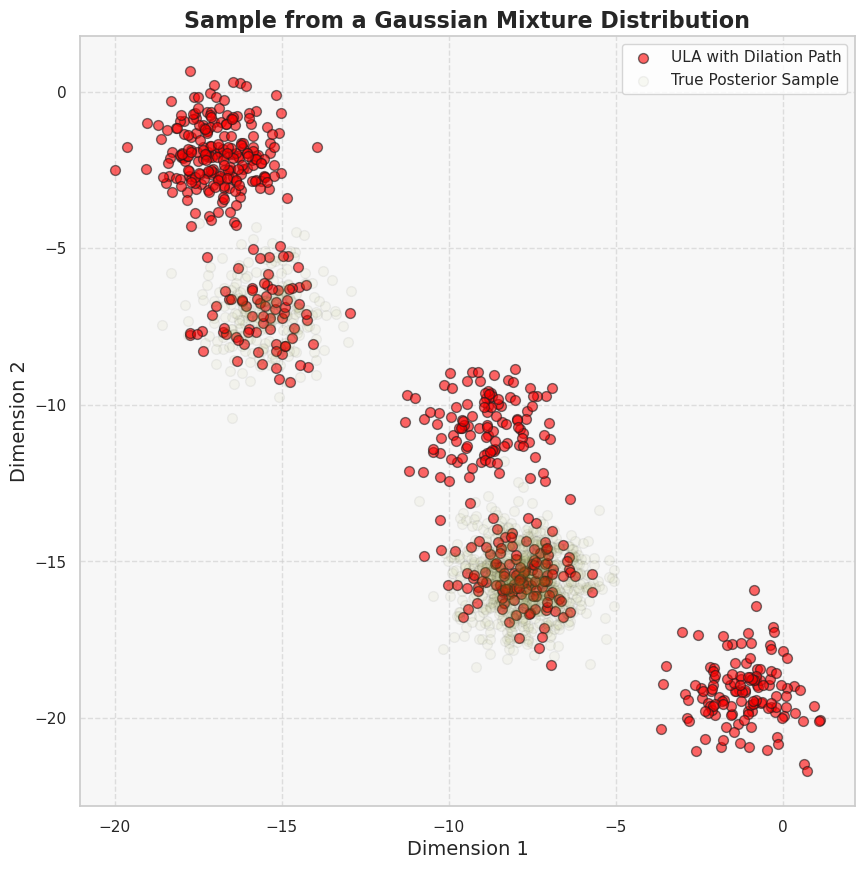

Dilation NaN 334


In [72]:
sample_init = sample_prior_dx(1000, params[0], params[1], params[2])

dilation_traj = ULA_dilation_exp(sample_init, 0.001, 5000, params[0], params[1], params[2], y_obs_dx, 0.1, theta_star, 0.6, 1, True)

print(f'Dilation NaN {np.sum(np.isnan(dilation_traj))//20}')

------------------------------------------------------------------------------------------------------------------------------------------
Comparison ULA vs ULA with Dilation Path to sample from the posterior distribution knowing $\theta^*$ :  

In [37]:
x_star = sample_prior_dx(1, params[0], params[1], params[2])
theta_star_list = [np.random.uniform(0, 1, 20), np.tile([-1, 0], 10), np.tile([-1, 1], 10), np.tile([3, 2], 10)]

y_obs_list = []

for i in range(len(theta_star_list)): 
    
    y_obs_list.append(generate_obs_dx(x_star, theta_star_list[i], 0.1))  ## generation of observation from the true_theta


/tmp/ipykernel_14966/562508489.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  weights_posteriori[i] = weights_prior[i] * norm.pdf(y_obs, mean_pdf, covariance_pdf)


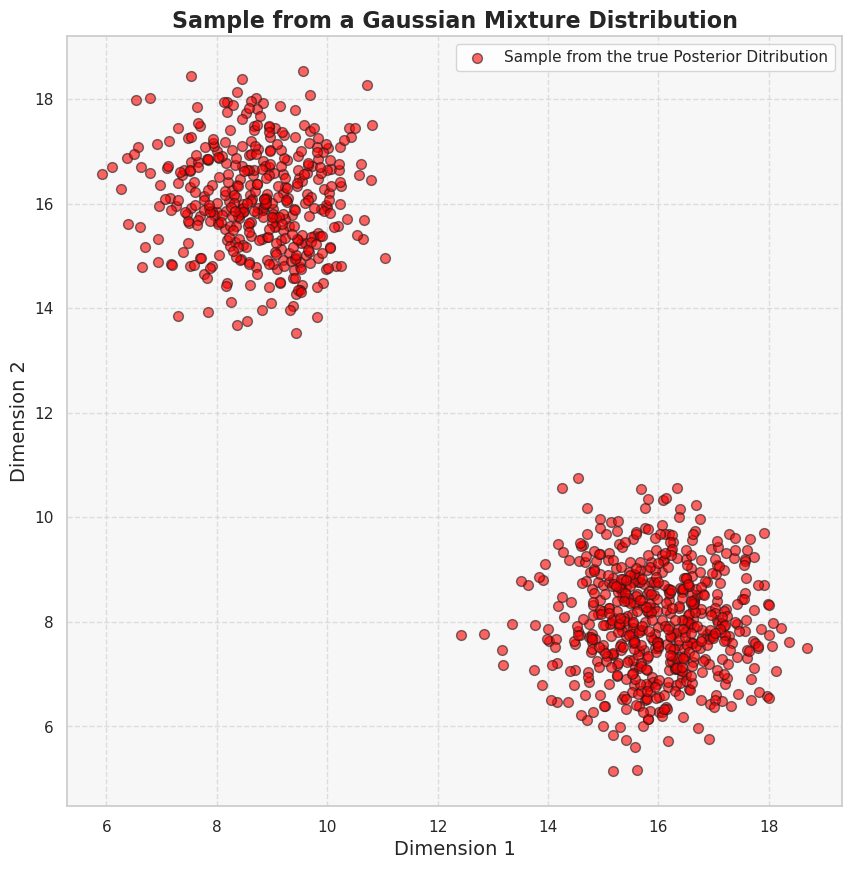

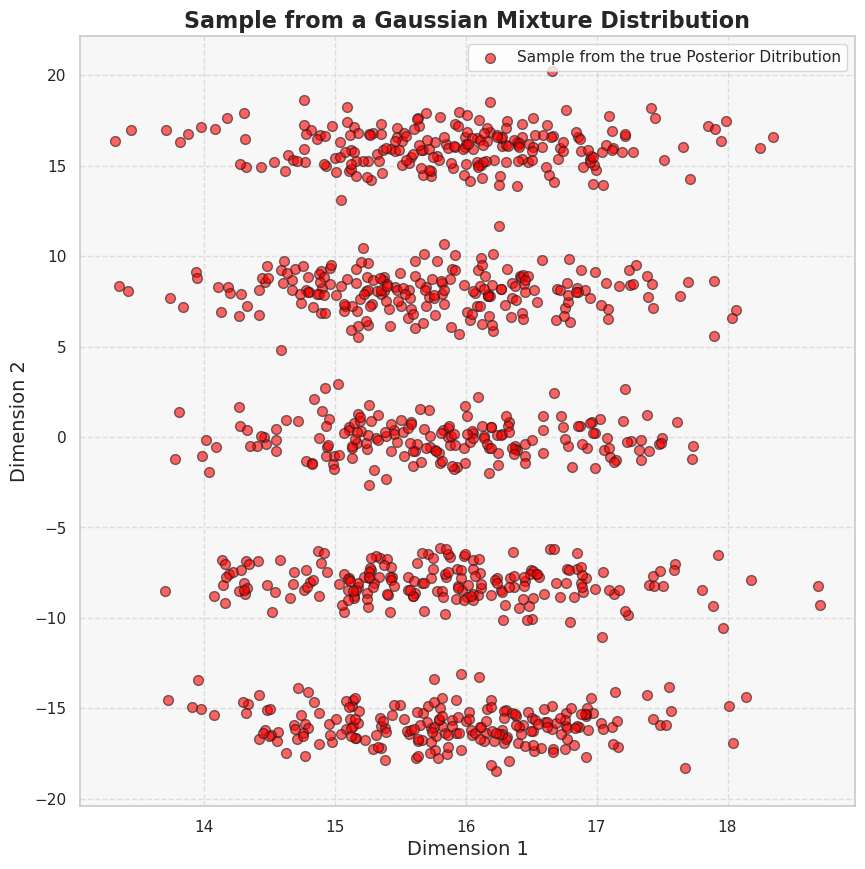

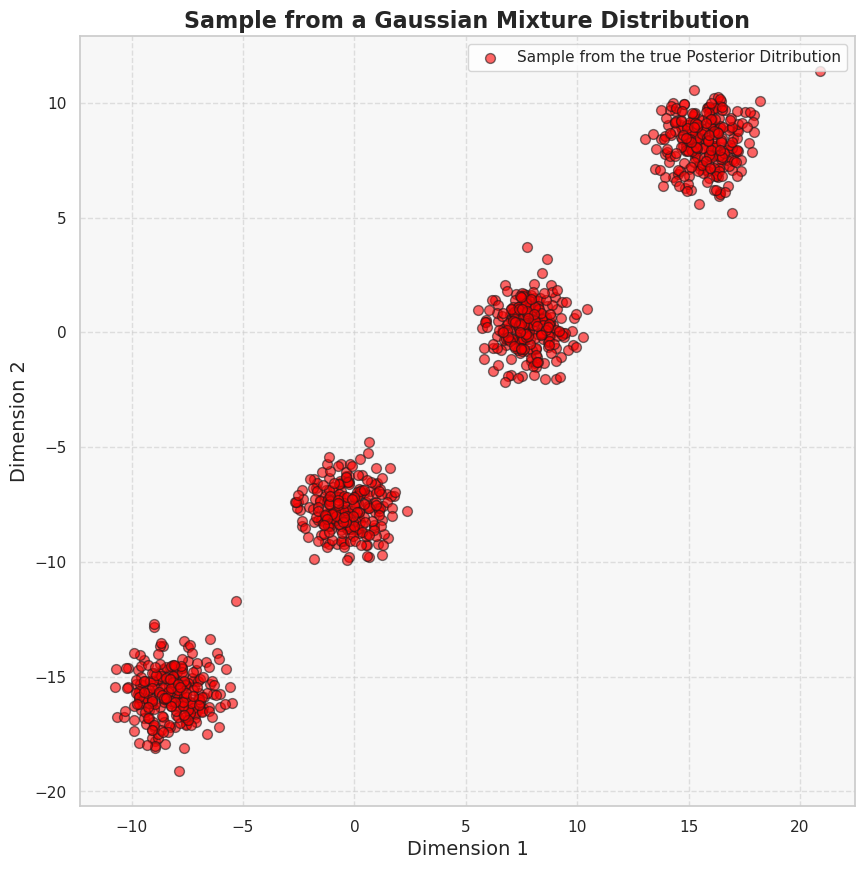

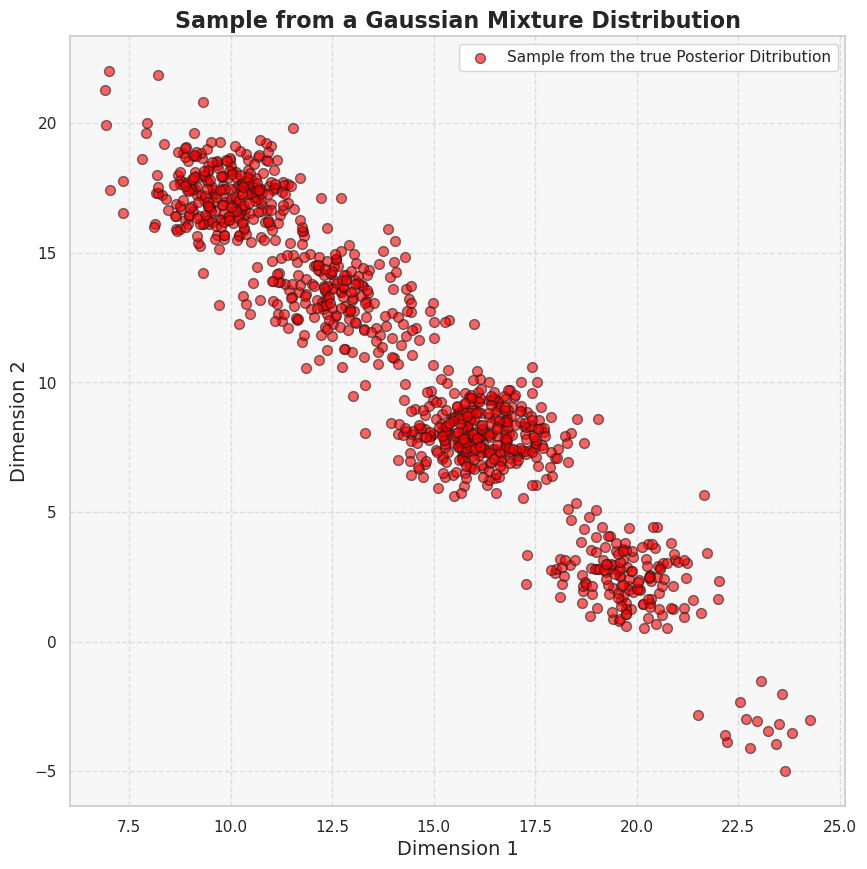

In [38]:
for i in range(len(theta_star_list)):

    centers_posteriori, covariances_posteriori, weights_posteriori = post_params_dx(theta_star_list[i], 0.1, params[0], params[1], params[2], y_obs_list[i])

    sample_post = sample_prior_dx(1000, centers_posteriori, covariances_posteriori, weights_posteriori)

    plot_sample_dx(sample_post, f'Sample from the true Posterior Ditribution')

100%|██████████| 1000/1000 [03:01<00:00,  5.50it/s]


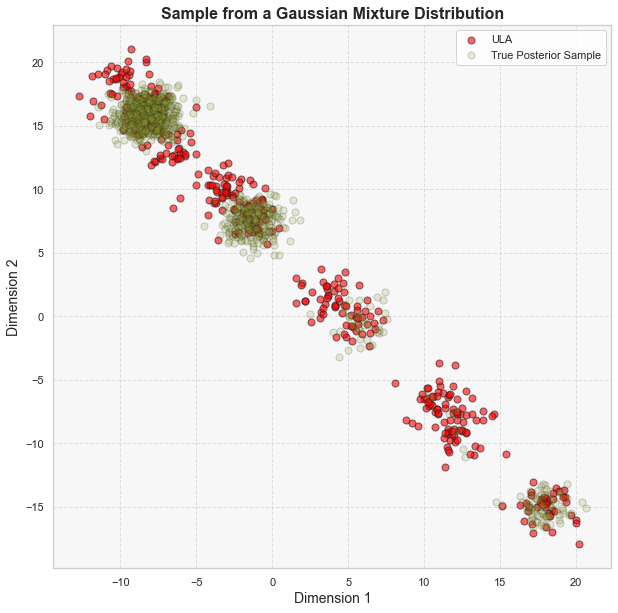

619


100%|██████████| 1000/1000 [02:50<00:00,  5.85it/s]


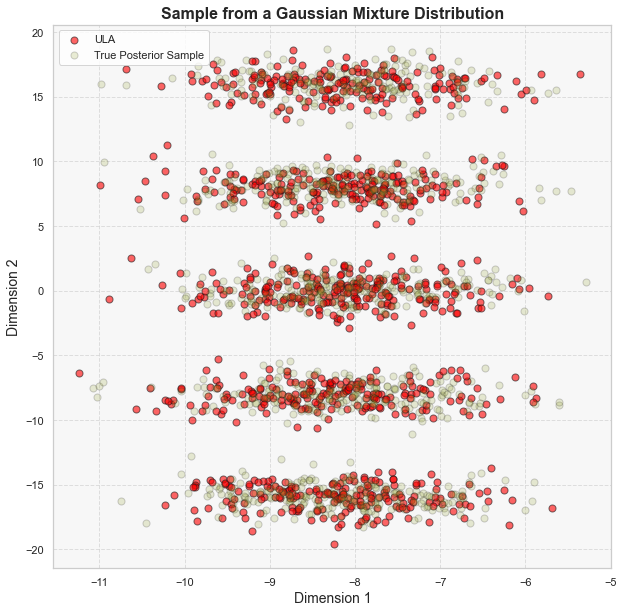

0


100%|██████████| 1000/1000 [02:42<00:00,  6.15it/s]


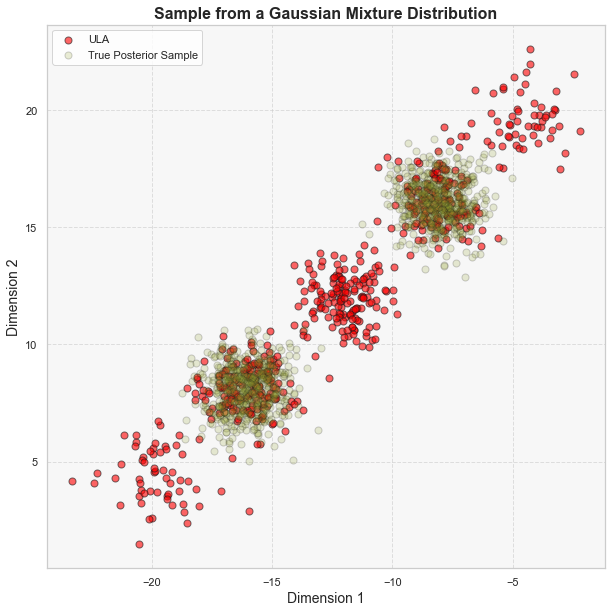

424


100%|██████████| 1000/1000 [02:44<00:00,  6.09it/s]


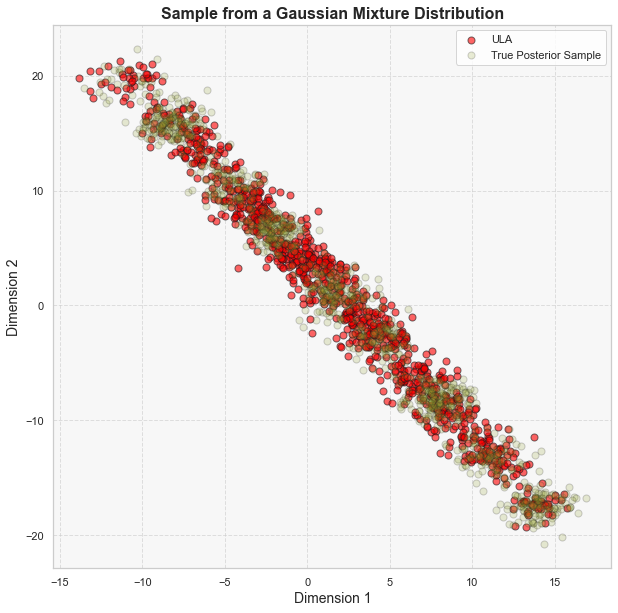

0


In [23]:
for i in range(len(theta_star_list)) : 

    sample_init = sample_prior_dx(1000, params[0], params[1], params[2])
    traj = ULA_post_dx(sample_init, 0.00001, 1000, params[0], params[1], params[2], y_obs_list[i], 0.1, theta_star_list[i], True)
    print(np.sum(np.isnan(traj)) // 80)

------------------------------------------------------------------------------------------------------------------------------------------
TESTS NOT PART OF THE NOTEBOOK : 

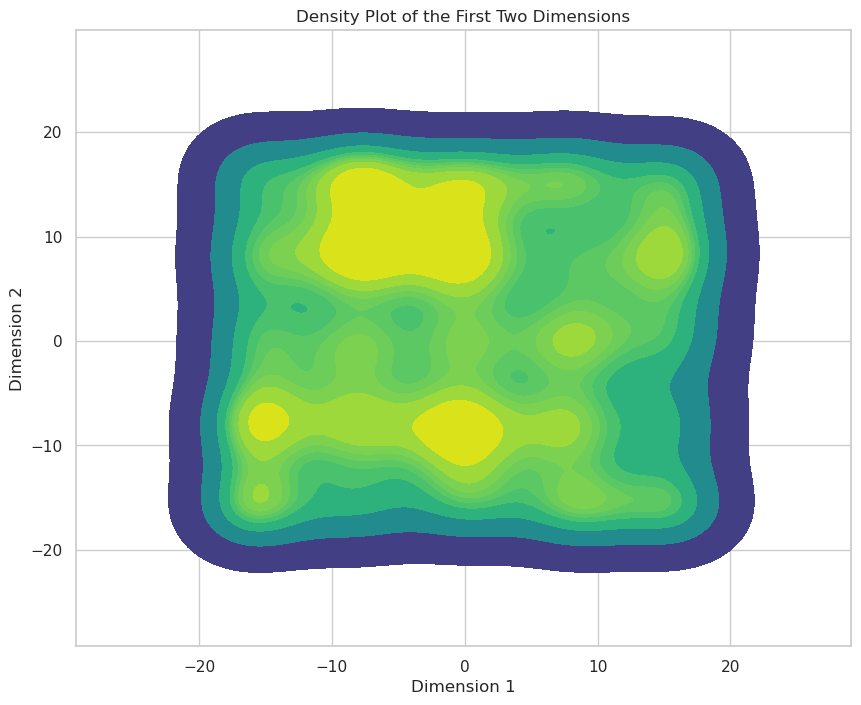

In [39]:
samples_2d = x_start

# Plot the density using seaborn
plt.figure(figsize=(10, 8))
sns.kdeplot(x=samples_2d[:, 0], y=samples_2d[:, 1], fill=True, cmap="viridis")
plt.title("Density Plot of the First Two Dimensions")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

No handles with labels found to put in legend.


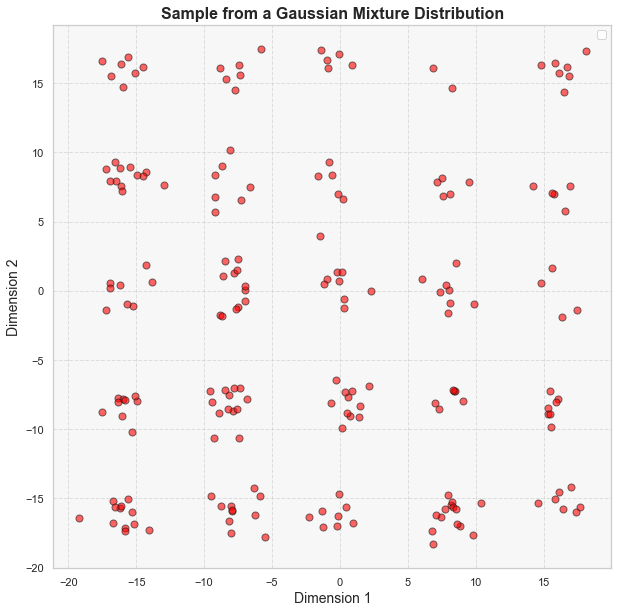

In [ ]:
sample_init = sample_prior_dx(200, means_prior, covariances_prior, weights_prior) 
plot_sample_dx(sample_init)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [01:02<00:00, 15.99it/s]


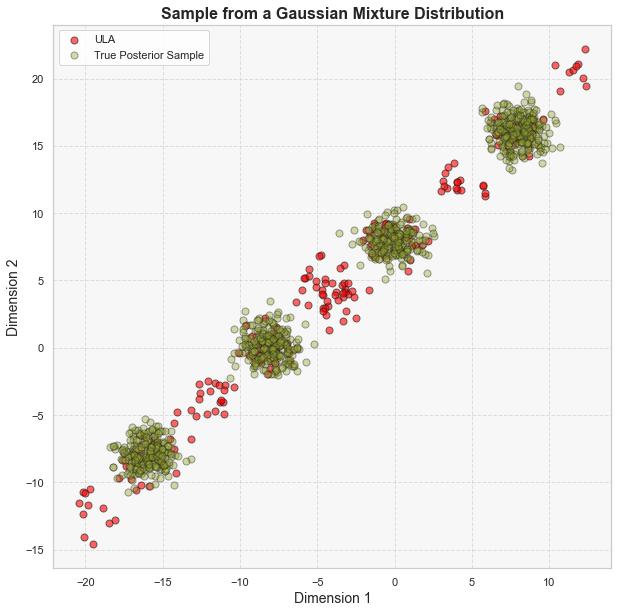

0

In [ ]:
traj = ULA_post_dx(sample_init, 0.000001, 1000, params[0], params[1], params[2], y_obs_list[i], 0.1, theta_star_list[i], True)
np.sum(np.isnan(traj)) // 80

In [30]:
def grad_multimodal_opti_precision(x, weights, centers, covariances): 
    
    n_components = len(weights)

    gradient = np.zeros(x.shape)

    covariance = covariances[0] #Warning : we assume that all the covariances are the same

    cov_inv = np.linalg.inv(covariance)

    pdf_tot = np.zeros(x.shape[0])

    for i in range(n_components):
        center = centers[i]
        weight = weights[i]

        pdf = multivariate_normal.pdf(x, mean = center, cov = covariance)

        #if np.sum(np.isnan(pdf)) != 0 :
        
         #   print(f'pdf step{np.sum(np.isnan(pdf))}') 

        #pdf_tot += pdf * weight #Denominator term
            
        diff = x - center

        gradient += weight * (np.einsum('ij,kj->ik', cov_inv, diff).T * pdf[:, np.newaxis]) #Numerator term

        #if np.sum(np.isnan(gradient)) != 0 :
         #   print(f'grad step{np.sum(np.isnan(gradient))}')

    #pdf_tot = np.maximum(pdf_tot, 1e-300) -> ce terme permet d'éviter les NaN mais fausse gravement les résultats
    
    gradient = (-1) * (gradient) #/ pdf_tot[:, np.newaxis])
    
    #if np.sum(np.isnan(gradient)) != 0 : 
    #    print(f'final step{np.sum(np.isnan(gradient))}')

    return gradient


In [31]:
def ULA_post_dx_precision(sample_init, step_size, nb_iter, centers_prior, covariances_prior, weights_prior, y_obs, sigma_y, true_theta, plot = True): 

    sample_size = sample_init.shape[0]
    dim_var = sample_init.shape[1]

    traj = np.zeros((nb_iter, sample_size, dim_var))

    for i in tqdm(range(nb_iter)): 
        
        #grad = grad_multimodal_opti(sample_init, weights_test, centers_test, covariances_test)
        grad = ((1/sigma_y**2) * true_theta[:, np.newaxis] * (y_obs - np.dot(true_theta, sample_init.T))).T 

        grad += grad_multimodal_opti_precision(sample_init, weights_prior, centers_prior, covariances_prior)
        #grad += np.nan_to_num(grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior), nan = 0)

        sample_init += step_size * grad + np.sqrt(step_size * 2) * np.random.randn(sample_size, dim_var)

        traj[i] = sample_init

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample_init, "ULA", sample_post, "True Posterior Sample") 

    return sample_init


In [ ]:
traj_precision = ULA_post_dx_precision(sample_init, 0.001, 300, means_prior, covariances_prior, weights_prior, y_obs_list[0], 0.1, theta_star_list[0], True)

print(f'Nombre NaN normal {np.sum(np.isnan(traj))//80}')
print(f'Nombre NaN precision {np.sum(np.isnan(traj_precision))//80}')

__________________________________________________________________________________________________________________________________________Encore une fois, on teste une méthode de calcul du gradient en passant au log, pas du tout plus efficace. 

In [688]:
def grad_multimodal_opti_NaN(x, weights, centers, covariances): 
    
    n_components = len(weights)

    gradient = np.zeros(x.shape)

    covariance = covariances[0] #Warning : we assume that all the covariances are the same

    cov_inv = np.linalg.inv(covariance)

    pdf_tot = np.zeros(x.shape[0])

    for i in range(n_components):
        center = centers[i]
        weight = weights[i]

        logpdf = multivariate_normal.logpdf(x, mean = center, cov = covariance)

        #if np.sum(np.isnan(pdf)) != 0 :
        
        #   print(f'pdf step{np.sum(np.isnan(pdf))}') 

        pdf_tot += np.exp(logpdf + np.log(weight)) #Denominator term
            
        diff = x - center

        gradient += (np.einsum('ij,kj->ik', cov_inv, diff).T) * np.exp(np.log(weight) + logpdf[:, np.newaxis]) #Numerator term

    #pdf_tot = np.maximum(pdf_tot, 1e-300) -> ce terme permet d'éviter les NaN mais fausse gravement les résultats
    
    gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])

    return gradient


In [689]:
def ULA_post_dx_test(sample_init, step_size, nb_iter, centers_prior, covariances_prior, weights_prior, y_obs, sigma_y, true_theta, plot = True): 

    sample_size = sample_init.shape[0]
    dim_var = sample_init.shape[1]

    traj = np.zeros((nb_iter, sample_size, dim_var))

    grad = np.zeros((sample_size, dim_var))

    for i in tqdm(range(nb_iter)): 
        
        #grad = grad_multimodal_opti(sample_init, weights_test, centers_test, covariances_test)
        #grad = ((1/sigma_y**2) * true_theta[:, np.newaxis] * (y_obs - np.dot(true_theta, sample_init.T))).T 

        grad += grad_multimodal_opti_NaN(sample_init, weights_prior, centers_prior, covariances_prior)
        #grad += np.nan_to_num(grad_multimodal_opti(sample_init, weights_prior, centers_prior, covariances_prior), nan = 0)

        sample_init += step_size * grad #+ np.sqrt(step_size * 2) * np.random.randn(sample_size, dim_var)

        traj[i] = sample_init

    if plot : 

        centers_post, covariances_post, weights_post = post_params_dx(true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)
        
        sample_post = sample_prior_dx(1000, centers_post, covariances_post, weights_post)
        
        plot_sample_dx(sample_init, "ULA", sample_post, "True Posterior Sample") 

    return sample_init


------------------------------------------------------------------------------------------------------------------------------------------
ICI PARTIE A PART ENTIÈRE : 
Here, we try our function on a lower dimension $dx = 2$, and we notice that it works very well !

In [65]:
#We define the grid

x = np.linspace(-16, 16, 5)
y = np.linspace(-16, 16, 5)

xx, yy = np.meshgrid(x, y)


## We define the parameters of the target Gaussian Mixture

# We define the centers for each mode
centers_prior_2 = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix and the weights : 

covariances_prior_2 = np.array([[[1, 0], [0, 1]]]*25)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights_prior_2 = np.ones(25) / 25


# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)

sample_init_2 = np.random.randn(20, 2) * 15


## Other parameters : 

nb_particles = 1000

step_size = 0.001

nb_iter = 10000

##Dimensions des variables

dx = 2

dy = 1

100%|██████████| 10000/10000 [01:06<00:00, 150.63it/s]


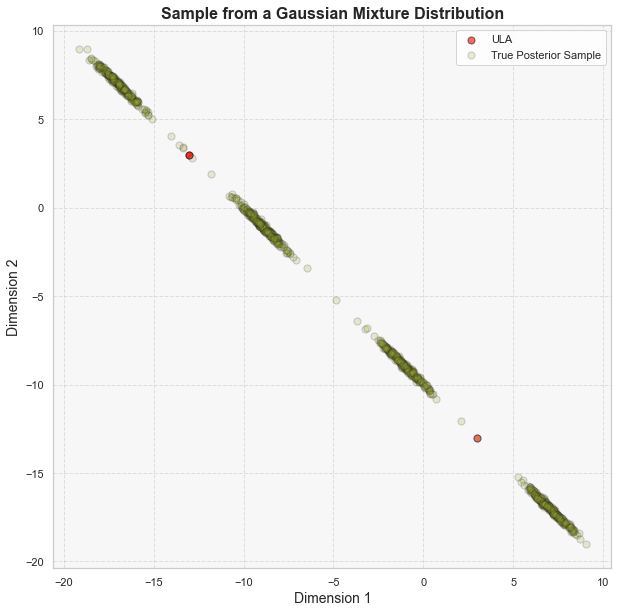

In [68]:
traj_test = grad_descent_post_dx(sample_init_2, 0.001, 10000, centers_prior_2, covariances_prior_2, weights_prior_2, np.array(-10), 0.1, np.array([1, 1]), True)

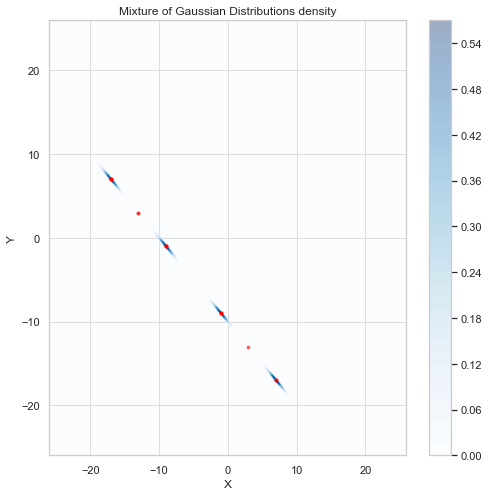

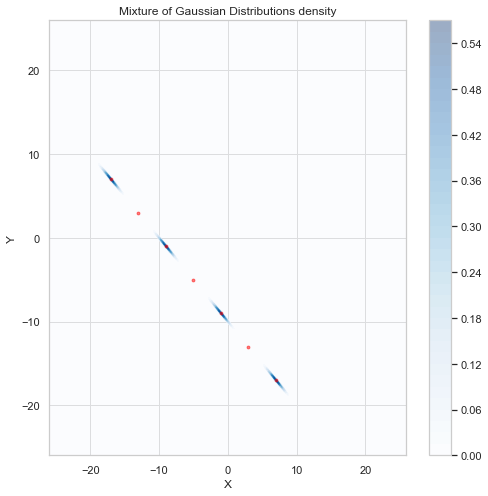

In [72]:
params_post = post_params_dx(np.array([1, 1]), 0.1, centers_prior_2, covariances_prior_2, weights_prior_2, np.array(-10))
generate_multimodal(params_post[0], params_post[1], params_post[2], traj_test)
generate_multimodal(params_post[0], params_post[1], params_post[2], params_post[0][params_post[2] > 0.001])

100%|██████████| 10000/10000 [01:28<00:00, 113.03it/s]


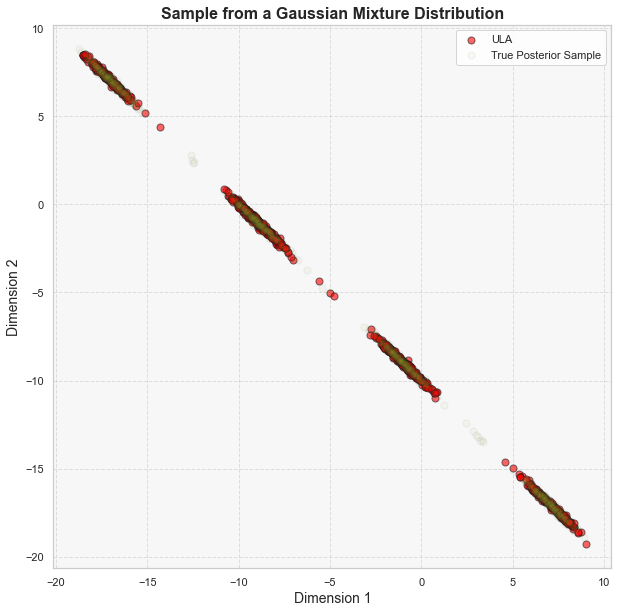

array([[-16.89768382,   6.97869852],
       [ -1.65246443,  -8.34493922],
       [-17.37669797,   7.31253552],
       ...,
       [ -9.73617942,  -0.23246986],
       [  0.37101747, -10.40388185],
       [ -8.90599773,  -1.00254964]])

In [82]:
sample_iniit = sample_prior_dx(1000, centers_prior_2, covariances_prior_2, weights_prior_2)
ULA_post_dx(sample_iniit, 0.001, 10000, centers_prior_2, covariances_prior_2, weights_prior_2, np.array(-10), 0.1, np.array([1, 1]), True)